# I am going to predict close price for next 30 days with Gated Recurrent Units and we will see what base-GRU Model predicts.

## Disclaimer

### This video and the corresponding source-code in this notebook is entirely for education purpose and NOT Financial Advice

### None of the content presented in this video constitutes a recommendation that any particular security, portfolio of securities, or investment strategy is suitable for any specific person.

## Futures, stocks and options trading involves substantial risk of loss and is not suitable for every investor. The valuation of futures, stocks and options may fluctuate, and, as a result, clients may lose more than their original investment.

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [2]:
# root_path = '../input/cs.csv' # local file
root_path = '/kaggle/input/credit-suisse-stock-price-last-10-year/cs.csv'

In [3]:
stock_df = pd.read_csv(root_path)
stock_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2012-10-04 00:00:00-04:00,16.079852,16.266911,16.022296,16.238132,2434867,0.0,0.0
1,2012-10-05 00:00:00-04:00,16.396413,16.583472,16.209354,16.238132,1529242,0.0,0.0
2,2012-10-08 00:00:00-04:00,15.971931,16.043877,15.907180,16.000710,1475891,0.0,0.0
3,2012-10-09 00:00:00-04:00,15.835236,15.928766,15.662567,15.698540,1475584,0.0,0.0
4,2012-10-10 00:00:00-04:00,15.820844,15.899984,15.705731,15.878401,2509722,0.0,0.0


In [4]:

stock_df = stock_df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
stock_df.head()

,date,open,high,low,close,volume,Dividends,Stock Splits
0,2012-10-04 00:00:00-04:00,16.079852,16.266911,16.022296,16.238132,2434867,0.0,0.0
1,2012-10-05 00:00:00-04:00,16.396413,16.583472,16.209354,16.238132,1529242,0.0,0.0
2,2012-10-08 00:00:00-04:00,15.971931,16.043877,15.907180,16.000710,1475891,0.0,0.0
3,2012-10-09 00:00:00-04:00,15.835236,15.928766,15.662567,15.698540,1475584,0.0,0.0
4,2012-10-10 00:00:00-04:00,15.820844,15.899984,15.705731,15.878401,2509722,0.0,0.0


In [5]:
print("Total number of days: ",stock_df.shape[0])
print("Total number of fields: ",stock_df.shape[1])

Total number of days:  2515
Total number of fields:  8


# Checking Null and NA value

In [6]:
print("Null values:", stock_df.isnull().values.sum())
print("NA values:", stock_df.isna().values.any())

Null values: 0
NA values: False


In [7]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          2515 non-null   object 
 1   open          2515 non-null   float64
 2   high          2515 non-null   float64
 3   low           2515 non-null   float64
 4   close         2515 non-null   float64
 5   volume        2515 non-null   int64  
 6   Dividends     2515 non-null   float64
 7   Stock Splits  2515 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 157.3+ KB


# Convert Date field into datetime format

In [8]:
# # convert date field from string to Date format 
# stock_df['date'] = pd.to_datetime(stock_df.date)
# stock_df.head()

stock_df['date'] = pd.to_datetime(stock_df['date'], utc=True)

In [9]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   date          2515 non-null   datetime64[ns, UTC]
 1   open          2515 non-null   float64            
 2   high          2515 non-null   float64            
 3   low           2515 non-null   float64            
 4   close         2515 non-null   float64            
 5   volume        2515 non-null   int64              
 6   Dividends     2515 non-null   float64            
 7   Stock Splits  2515 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 157.3 KB


### Find the duration of dataset

In [10]:
print("Starting date: ",stock_df.iloc[0][0])
print("Ending date: ", stock_df.iloc[-1][0])
print("Duration: ", stock_df.iloc[-1][0]-stock_df.iloc[0][0])

Starting date:  2012-10-04 04:00:00+00:00
Ending date:  2022-10-03 04:00:00+00:00
Duration:  3651 days 00:00:00


In [11]:
# stock_df['date'] = pd.to_datetime(stock_df['date'], utc=True)

# Trend comparision between stock open price, close price, high price, low price

In [12]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(stock_df, x=stock_df.date, y=[stock_df['open'], stock_df['close'], 
                                          stock_df['high'], stock_df['low']],
             labels={'date': 'Date','value':'Stock value'})

fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

# Prepare Stock Close price

# Make separate dataframe of close price

In [13]:
stock_df_close = stock_df[['date','close']]

print("Shape of close dataframe:", stock_df_close.shape)

Shape of close dataframe: (2515, 2)


# Taking only only last 1 year data for prediction

In [14]:
stock_df_close_last_1_year = stock_df_close[stock_df_close['date'] > '2021-10-03']

stock_df_close_last_1_year_original_gt = stock_df_close_last_1_year.copy()

print("Total data for prediction: ",stock_df_close_last_1_year.shape[0])

Total data for prediction:  252


In [15]:
fig = px.line(stock_df_close_last_1_year, x=stock_df_close_last_1_year.date, y=stock_df_close_last_1_year.close,labels={'date':'Date','close':'Close Stock'})

fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')

fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

# Train Test Split before Normalization

Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.

This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.


After splitting the data into train, validation, and test sets, the optimal approach is to first normalize the train set, then apply the mean and standard deviation of the train set normalization to the validation and test set normalization.

### Key rule is fit() should NOT be used on test data, as test data should remain in its pristine form. The model should NOT learn it.

We use **`fit_transform()`** on the train data so that we learn the parameters of scaling on the train data and in the same time we scale the train data. 

And then, we only use **`transform()`** on the test data because we use the scaling parameters learned on the train data to scale the test data.

In [ ]:
training_size=int(len(stock_df_close_last_1_year)*0.80)

test_size=len(stock_df_close_last_1_year)-training_size

train_data,test_data = stock_df_close_last_1_year[0:training_size],stock_df_close_last_1_year[training_size:len(stock_df_close_last_1_year)]

print("train_data: ", train_data.shape)

print("test_data: ", test_data.shape)

# Normalizing close price


### Key rule is fit() should NOT be used on test data, as test data should remain in its pristine form. The model should NOT learn it.

In [16]:
# Need to delte the 'date' column else will get below error
# float() argument must be a string or a number, not 'Timestamp'
del train_data['date']
del test_data['date']

(252, 1)


In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))

train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

test_data = scaler.transform(np.array(test_data).reshape(-1,1))

print(stock_df_close_last_1_year.shape)

### Transform Close price base on Time-series-analysis forecasting requirement

## Using lagged observations as features

Look at the below image to get bit of understanding about create dataset for forecasting time-series-analysis

Let’s start with using time steps as features. In other words, we’re trying to predict the next value, X(t+n), from the previous n observations Xt, X+1, …, and X(t+n-1).

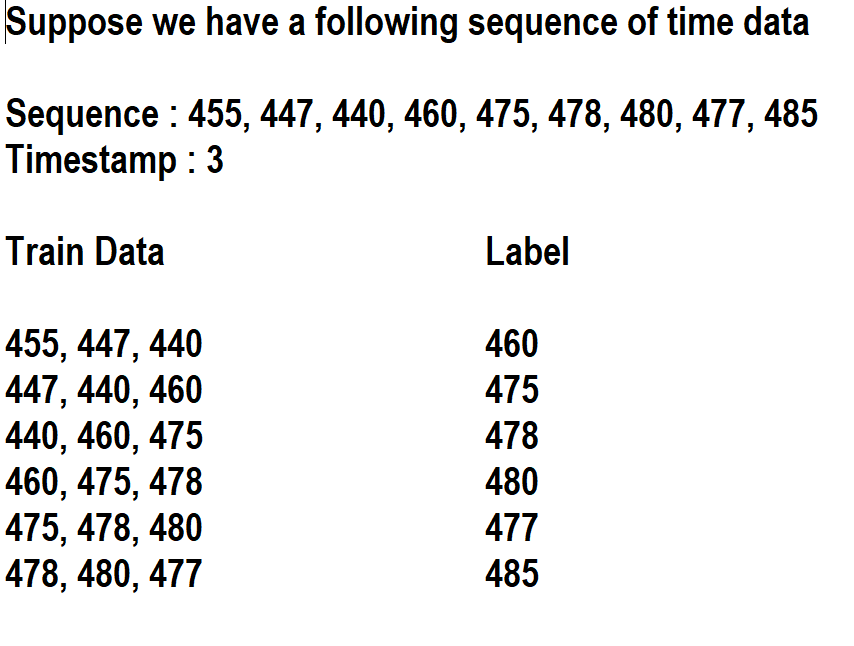


In [54]:
# convert an array of values into a dataset matrix
def create_sliding_window(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [55]:
time_step = 15
X_train, y_train = create_sliding_window(train_data, time_step)
X_test, y_test = create_sliding_window(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (135, 15)
y_train:  (135,)
X_test:  (85, 15)
y_test (85,)


# For LSTM I need to reshape input to be a 3D Tensor of [samples, time steps, features]

    X = numpy.reshape(dataX, (len(dataX), seq_length, 1))

**Samples** - This is the len(dataX), or the amount of data points you have.

**Time steps** - A sample contains multiple time steps, and here time_steps means, the width of the sliding window (in this case its is 15).
Note here that **Time steps** is distinguished from the sliding step of the sliding window. This is equivalent to the amount of time steps you run your recurrent neural network. If you want your network to have memory of 60 characters, this number should be 60. For this notebook, I am using the window-size to be 5.

**Features** - this is the number of features in every time step. In this case I have 1 feature (the closing price of the assets) per time step.

 ### So when working with TensorFlow/Keras - the above requirement of a 3D Tensor of [samples, time steps, features] for LSTM input data is equivalent to [batch_size, timesteps, input_dim].

 In Keras, the number of time steps is equal to the number of LSTM cells. This is what the word “time steps” means in the 3D tensor of the shape [batch_size, timesteps, input_dim].

----------------------------------

## So to emphasize again, the input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

Samples. One sequence is one sample. A batch is comprised of one or more samples.

Time Steps. One time step is one point of observation in the sample.

Features. One feature is one observation at a time step.

This means that the input layer expects a 3D array of data when fitting the model and when making predictions, even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

When defining the input layer of your LSTM network, the network assumes you have 1 or more samples and requires that you specify the number of time steps and the number of features. You can do this by specifying a tuple to the “input_shape” argument.

-----------------------



# VERY IMPORTANT - Example of reshaping input data for LSTM With Single Input Sample (i.e. single row of data) where you have one sequence of multiple time steps and one feature.

For example, this could be a sequence of 10 values:

```
0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0

```

1. We can define this sequence of numbers as a NumPy array.

2. We can then use the reshape() function on the NumPy array to reshape this one-dimensional array into a three-dimensional array with 1 sample, 10 time steps, and 1 feature at each time step.

The reshape() function when called on an array takes one argument which is a tuple defining the new shape of the array. We cannot pass in any tuple of numbers; the reshape must evenly reorganize the data in the array.

3. Once reshaped, we can print the new shape of the array.

Putting all of this together, the complete example is listed below.

```py
from numpy import array
data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
data = data.reshape((1, 10, 1))
print(data.shape)

```
Running the example prints the new 3D shape of the single sample.

```
(1, 10, 1)

```
This data is now ready to be used as input (X) to the LSTM with an input_shape of (10, 1).

```py
model = Sequential()
model.add(LSTM(32, input_shape=(10, 1)))
model.add(Dense(1))

```

----------------------------------

In [56]:
# reshape input to be [samples, time steps, features] which is required for LSTM
# Or in terms of TensorFlow / Keras => [batch_size, time steps, input_dim].
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (135, 15, 1)
X_test:  (85, 15, 1)


# Model Building (GRU)

Gated Recurrent Units (GRU) very similar to Long Short Term Memory(LSTM), but is slightly more streamlined variant that provides comparable performance and considerably faster computation. Like LSTMs, they also capture long-term dependencies, but they do so by using reset and update gates without any cell state.

While the update gate determines how much of the past information needs to be kept, the reset gate decides how much of the past information to forget. Doing fewer tensor operations, GRUs are often faster and require less memory than LSTMs.

In [57]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 15, 32)            3360      
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 32)            6336      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
5/5 [==============================] - 4s 212ms/step - loss: 0.3266 - val_loss: 0.0038
Epoch 2/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0499 - val_loss: 0.0573
Epoch 3/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0467 - val_loss: 0.0714
Epoch 4/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0348 - val_loss: 0.0318
Epoch 5/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0191 - val_loss: 0.0154
Epoch 6/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0245 - val_loss: 0.0176
Epoch 7/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0168 - val_loss: 0.0287
Epoch 8/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0155 - val_loss: 0.0361
Epoch 9/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0151 - val_loss: 0.0303
Epoch 10/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0119 - val_loss: 0.0207
Epoch 11/200
5/5 [

### Plotting loss chart

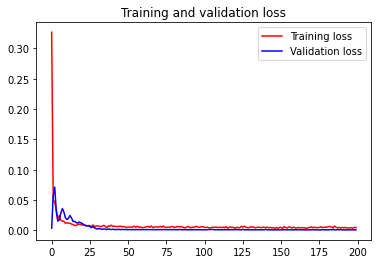

<Figure size 432x288 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')

plt.legend(loc=0)

plt.figure()


plt.show()

In [61]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((135, 1), (85, 1))

# Model Evaluation - Transform back the data (i.e. Inverse Scaling)

In [62]:
train_predict = scaler.inverse_transform(train_predict)

test_predict = scaler.inverse_transform(test_predict)

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 

original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

### Evaluation metrices RMSE, MSE and MAE

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [63]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))

print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))

print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("-------------------------------------------------------------------------------------")

print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))

print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))

print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.3289783309389697
Train data MSE:  0.10822674222739029
Train data MAE:  0.28025315249407734
-------------------------------------------------------------------------------------
Test data RMSE:  0.2141211468696085
Test data MSE:  0.04584786553675646
Test data MAE:  0.16816042451297536


# Explained variance regression score

explained_variance_score, EVS tells you how much variance is explained by your model. The maximum value is one. Higher the EVS better is your model.

The formula is written as follows: taken from [scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score)

![](2022-10-04-22-38-55.png)

Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [64]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))

print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9594222184197718
Test data explained variance regression score: 0.8843354355496351


# R<sup>2</sup> score for regression

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best <br>
0 or < 0 = worse

---------

## Difference between r2_score and explained_variance_score?

The difference is that the explained variance use the biased variance to determine what fraction of the variance is explained. R-Squared uses the raw sums of squares. If the error of the predictor is unbiased, the two scores are the same.

The main difference is the **Mean of Error**; and if we look at the formulas

## $$R2 = 1 - [(Sum of Squared Residuals / n) / Variancey_actual]$$

## $$Explained Variance Score = 1 - [Variance(Ypredicted - Yactual) / Variancey_actual]$$

in which:

## Variance(Ypredicted - Yactual) = (Sum of Squared Residuals - Mean Error) / n


So, obviously the only difference is that we are subtracting the Mean Error from the first formula! ... But Why?

------------------

When we compare the R2 Score with the Explained Variance Score, we are basically checking the Mean Error; so if R2 = Explained Variance Score, that means: The Mean Error = Zero!

The Mean Error reflects the tendency of our estimator, that is: the Biased v.s Unbiased Estimation.

## If you want to have unbiased estimator so our model is not underestimating or overestimating, you may consider taking Mean of Error into account.

### Explained Variance score does not account for systematic offsets in the prediction.

In [65]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9180042506003877
Test data R2 score: 0.8802696919541564


---------------

### Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [66]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))

print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")

print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))

print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0014196638608752676
Test data MGD:  0.0016954608878279435
----------------------------------------------------------------------
Train data MPD:  0.01228276333630143
Test data MPD:  0.00875631701296593


# Comparison of original stock close price and predicted close price

**`np.empty_like()`** => Return a new array with the same shape and type as a given array.

In [67]:
# shift train predictions for plotting the look-ahead time for predicted stock values
# And I need this shifting because for the first window of look_back there is NO prediction
# Basically I start at the end-point of the first sliding window
# Note 'train_predict' was defined as train_predict=model.predict(X_train)

look_back=time_step

train_predict_look_ahead = np.empty_like(stock_df_close_last_1_year)

train_predict_look_ahead[:, :] = np.nan

# For looking ahead by look_back, I need to start at look_back
train_predict_look_ahead[look_back:len(train_predict)+look_back, :] = train_predict

print("Train predicted data: ", train_predict_look_ahead.shape)

####################### TEST #############################
# shift test predictions for plotting
test_predict_look_ahead = np.empty_like(stock_df_close_last_1_year)

test_predict_look_ahead[:, :] = np.nan

test_predict_look_ahead[len(train_predict)+(look_back*2)+1:len(stock_df_close_last_1_year)-1, :] = test_predict

print("Test predicted data: ", test_predict_look_ahead.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': stock_df_close_last_1_year_original_gt['date'],
                       'original_close': stock_df_close_last_1_year_original_gt['close'],
                      'train_predicted_close': train_predict_look_ahead.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': test_predict_look_ahead.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (252, 1)
Test predicted data:  (252, 1)


# Predicting next 30 days based on previous 15 days of actual historical values

- a[start:]      # items start through the rest of the array

In [68]:
len(test_data) # 51
len(test_data)-time_step # 36

86

In [69]:
e = test_data[len(test_data)-time_step:]
e

array([[0.19899143],
       [0.20331729],
       [0.20475929],
       [0.18889763],
       [0.19033956],
       [0.16582619],
       [0.1557324 ],
       [0.11391537],
       [0.03172324],
       [0.01874558],
       [0.00865179],
       [0.02307145],
       [0.        ],
       [0.        ],
       [0.01297772]])

In [70]:
e.shape

(15, 1)

### Need to convert to this (15, 1) matrix to (1, 15) Matrix

In [71]:
e.reshape(1, -1)

array([[0.19899143, 0.20331729, 0.20475929, 0.18889763, 0.19033956,
        0.16582619, 0.1557324 , 0.11391537, 0.03172324, 0.01874558,
        0.00865179, 0.02307145, 0.        , 0.        , 0.01297772]])

In [72]:
# for x_input, I need to pick the last 15 days
# a[start:]      # items starts at the index specified by 'start' and goes through the rest of the array
# So below I start at "len(test_data)-time_step" and go till the rest of the array
# i.e the x_input.shape will always be (15, 1)

x_input=test_data[len(test_data)-time_step:].reshape(1,-1) # time_step is 15
print("x_input.shape ", x_input.shape)
print("x_input", x_input)

print('###########################################################################')

temp_input=list(x_input)
print(temp_input)

x_input.shape  (1, 15)
x_input [[0.19899143 0.20331729 0.20475929 0.18889763 0.19033956 0.16582619
  0.1557324  0.11391537 0.03172324 0.01874558 0.00865179 0.02307145
  0.         0.         0.01297772]]
###########################################################################
[array([0.19899143, 0.20331729, 0.20475929, 0.18889763, 0.19033956,
       0.16582619, 0.1557324 , 0.11391537, 0.03172324, 0.01874558,
       0.00865179, 0.02307145, 0.        , 0.        , 0.01297772])]


In [73]:
temp_input=temp_input[0].tolist()
len(temp_input)

15

In [74]:
from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        y_pred = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,y_pred))
        temp_input.extend(y_pred[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(y_pred.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1)) # Reshape x_input to a 3D Tensor [samples, time steps, features] before feeding into the model 
        y_pred = model.predict(x_input, verbose=0)
        temp_input.extend(y_pred[0].tolist())
        
        lst_output.extend(y_pred.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [75]:
lst_output

[[0.0006340965628623962],
 [-0.001458190381526947],
 [-0.0038221627473831177],
 [-0.006202302873134613],
 [-0.008521541953086853],
 [-0.01076536625623703],
 [-0.012947514653205872],
 [-0.015070930123329163],
 [-0.01715157926082611],
 [-0.019205741584300995],
 [-0.021213367581367493],
 [-0.023178592324256897],
 [-0.025096192955970764],
 [-0.026980727910995483],
 [-0.02882404625415802],
 [-0.03062385320663452],
 [-0.03239035606384277],
 [-0.03411981463432312],
 [-0.03581351041793823],
 [-0.03747238218784332],
 [-0.03909723460674286],
 [-0.04068881273269653],
 [-0.042247891426086426],
 [-0.04377521574497223],
 [-0.04527150094509125],
 [-0.0467374324798584],
 [-0.04817371070384979],
 [-0.04958099126815796],
 [-0.05095990002155304],
 [-0.052311092615127563]]

## `.append()` vs `.extend()`, let's see a summary of their key differences:

- Effect: .append() adds a single element to the end of the list while .extend() can add multiple individual elements to the end of the list.

- Argument: .append() takes a single element as argument while .extend() takes an iterable as argument (list, tuple, dictionaries, sets, strings).

# Plotting last 15 days of dataset and next predicted 30 days

In [76]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [77]:
temp_matrix = np.empty((len(last_days)+pred_days+1, 1))

temp_matrix[:] = np.nan

temp_matrix

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

In [78]:
temp_matrix.shape

(46, 1)

### Need to convert to this (46, 1) matrix to (1, 46) Matrix

In [79]:
temp_matrix = temp_matrix.reshape(1,-1).tolist()[0]


## Now for Predicting next 30 days based on previous 15 days of actual historical values - I need a single list in which the first 15 elements will be the 15 days of actual historical values and the next 30 days will be the predicted values


So in below I am initially creating 2 variables and setting them equal to the same variable `temp_index`

### That means after I update the values of these 2 variables, by assignment, I will have 2 equal list.

Because of the way Python Variable assignment works. The explanations is in below.



In [80]:
last_original_days_value = temp_matrix

next_predicted_days_value = temp_matrix

last_original_days_value[0:time_step+1] = stock_df_close_last_1_year_original_gt[len(stock_df_close_last_1_year_original_gt)-time_step:]['close'].tolist()

next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

----------------------------

# Python List Copy and Mutation Theory

## The reason around temp_matrix and why after running the above, the `last_original_days_value` will have the last 30 days stock-value picked up from `next_predicted_days_value`

### Its happening because `last_original_days_value` and `next_predicted_days_value` both have been made equal to `temp_matrix` and hence any changes made by assignment (which we are indeed doing) made to `last_original_days_value` or `next_predicted_days_value` will change `temp_matrix`


While using 

`new_list = my_list`

any modifications to 

`new_list` changes `my_list` every time. 

Why is this ?

# ANS

### `new_list = my_list` doesn't actually create a second list. 

### The assignment just copies the reference to the list, not the actual list, so both `new_list` and `my_list` refer to the same list after the assignment.

To actually copy the list, you have several options:

You can use the builtin `list.copy()` method (available since Python 3.3):

```py
new_list = old_list.copy()

```

You can slice it:

```py
new_list = old_list[:]
```

Python doesn't store anything in a variable, Variables are just referencing to the object and object store the value. Here object is a list but we created two references to that same object by two different variable names. This means that both variables are pointing to the same object, just with different names.

When you do **`copy = list_1`**, it is actually doing:

![Imgur](https://imgur.com/xcTXlLj.png)

----------------------------

## So in above, if I really wanted to create 2 different lists, I needed to to like below.

```py
temp_matrix = temp_matrix.reshape(1,-1).tolist()[0]

copy_temp_matrix = temp_matrix[:]

last_original_days_value = copy_temp_matrix

next_predicted_days_value = temp_matrix
```

In [81]:
last_original_days_value[0:time_step+1]

[5.300000190734863,
 5.329999923706055,
 5.340000152587891,
 5.230000019073486,
 5.239999771118164,
 5.070000171661377,
 5.0,
 4.710000038146973,
 4.139999866485596,
 4.050000190734863,
 3.9800000190734863,
 4.079999923706055,
 3.920000076293945,
 3.920000076293945,
 4.010000228881836,
 nan]

In [82]:
next_predicted_days_value[time_step+1:]

[3.924397518686546,
 3.9098875657146968,
 3.893493481744854,
 3.8769872748004977,
 3.860903414950001,
 3.845342554522559,
 3.8302094148246217,
 3.8154835863746532,
 3.8010543412766244,
 3.786808781512419,
 3.7728859499043486,
 3.759257169839116,
 3.7459586616877507,
 3.732889463103617,
 3.720106100600133,
 3.7076244884059397,
 3.69537383920533,
 3.6833800911242056,
 3.6716343569959227,
 3.660130126454219,
 3.6488618191851563,
 3.637824268231383,
 3.6270120999572546,
 3.61642014740542,
 3.6060434502968226,
 3.5958772550306994,
 3.5859167046671407,
 3.5761572522836778,
 3.5665945576361358,
 3.557224073802046]

In [83]:
len(last_original_days_value[0:time_step+1])

16

In [84]:
len(next_predicted_days_value[time_step+1:])

30

## Key point of above 2 lists getting updated to the same value

From above see that, for `last_original_days_value` I have only assigned the value for the first 15 elements with this line 

```
last_original_days_value[0:time_step+1] = stock_df_close_last_1_year_original_gt[len(stock_df_close_last_1_year_original_gt)-time_step:]['close'].tolist()
```

## BUT for `last_original_days_value` the last 30 days values also got assigned by taking the values from `next_predicted_days_value`

Verify it by running the below equality checking code - both will output True

```py
import collections
x = last_original_days_value[time_step+1:]
y = next_predicted_days_value[time_step+1:]
collections.Counter(x) == collections.Counter(y) # True
sorted(x) == sorted(y) # True

```

In [85]:
new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

new_pred_plot.tail()


,last_original_days_value,next_predicted_days_value
41,3.595877,3.595877
42,3.585917,3.585917
43,3.576157,3.576157
44,3.566595,3.566595
45,3.557224,3.557224


In [86]:
new_pred_plot.shape

(46, 2)

In [87]:

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'], new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})

fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(visible=True, name = next(names)))

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

# Plotting entire Closing Stock Price with next 30 days period of prediction 

In [88]:
lstmdf=stock_df_close_last_1_year.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()